In [ ]:
import importlib
import os

from dotenv import load_dotenv

import art.utils.benchmarking.charts
from art.utils.benchmarking.charts import (
    percentage_comparison_bar_chart,
    training_progress_chart,
)
from art.utils.benchmarking.load_trajectories import load_trajectories
from art.utils.benchmarking.types import BenchmarkModelKey
from art.utils.get_repo_root_path import get_repo_root_path
from art.utils.s3 import pull_model_from_s3

importlib.reload(art.utils.benchmarking.charts)


load_dotenv()

project_name = "mcp_alphavantage"

PULL_MODELS = True
if PULL_MODELS:
    await pull_model_from_s3(
        model_name="mcp-14b-alpha-004",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o-mini",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4.1",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="sonnet-4",
        project=project_name,
    )

df = await load_trajectories(
    project_name=project_name,
    models=["mcp-14b-alpha-004", "gpt-4o-mini", "gpt-4o", "gpt-4.1", "sonnet-4"],
)


benchmarks_dir = f"{get_repo_root_path()}/assets/benchmarks/{project_name}"

os.makedirs(benchmarks_dir, exist_ok=True)

Models:   0%|          | 0/7 [00:00<?, ?model/s]

mcp-14b-alpha-004/train:   0%|          | 0/54 [00:00<?, ?file/s]

mcp-14b-alpha-004/val:   0%|          | 0/54 [00:00<?, ?file/s]

o4-mini/val:   0%|          | 0/1 [00:00<?, ?file/s]

gpt-4.1/val:   0%|          | 0/1 [00:00<?, ?file/s]

gpt-4o/val:   0%|          | 0/1 [00:00<?, ?file/s]

o3/val:   0%|          | 0/1 [00:00<?, ?file/s]

sonnet-4/val:   0%|          | 0/1 [00:00<?, ?file/s]

gpt-4o-mini/val:   0%|          | 0/1 [00:00<?, ?file/s]

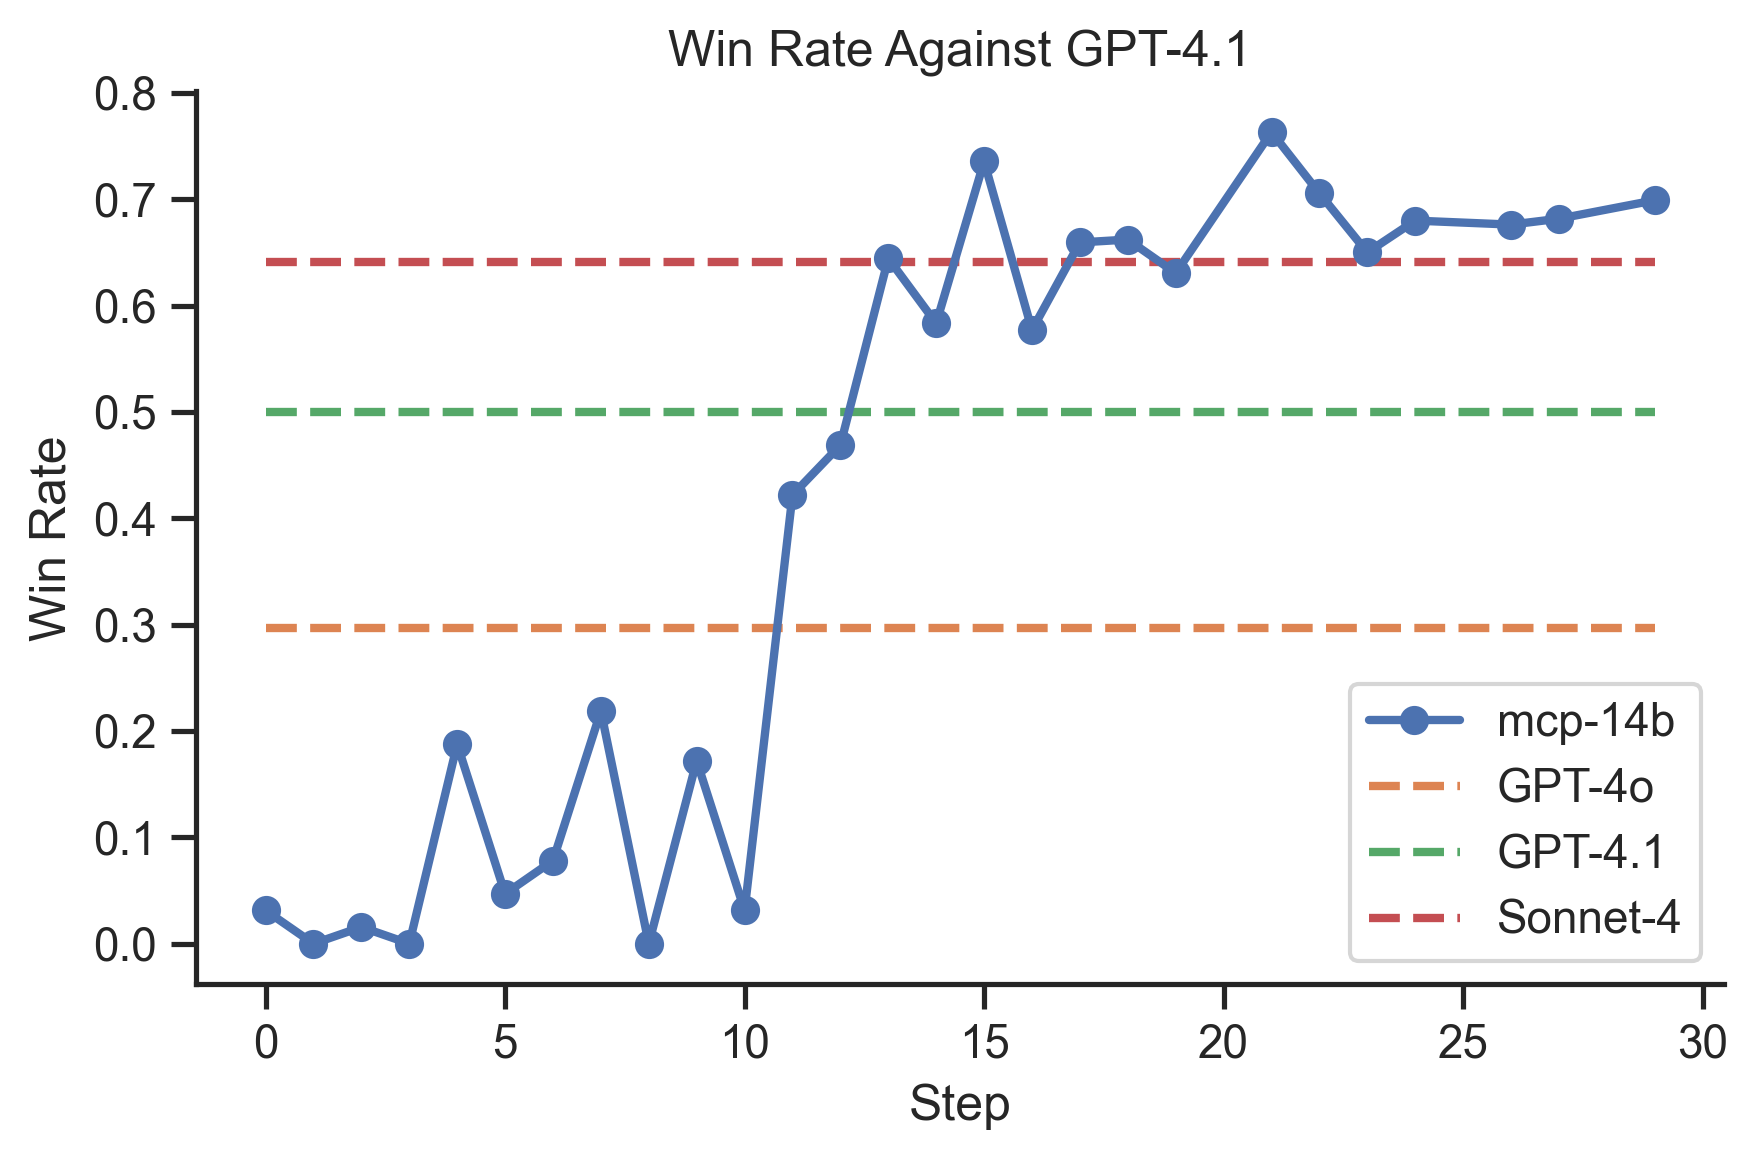

In [94]:
line_graph = training_progress_chart(
    df,
    "beat_comp_control_last",
    models=[
        BenchmarkModelKey("mcp-14b-alpha-004", "mcp-14b", "val"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("sonnet-4", "Sonnet-4"),
    ],
    title="Win Rate Against GPT-4.1",
    y_label="Win Rate",
)
line_graph.savefig(f"{benchmarks_dir}/accuracy-training-progress.svg")

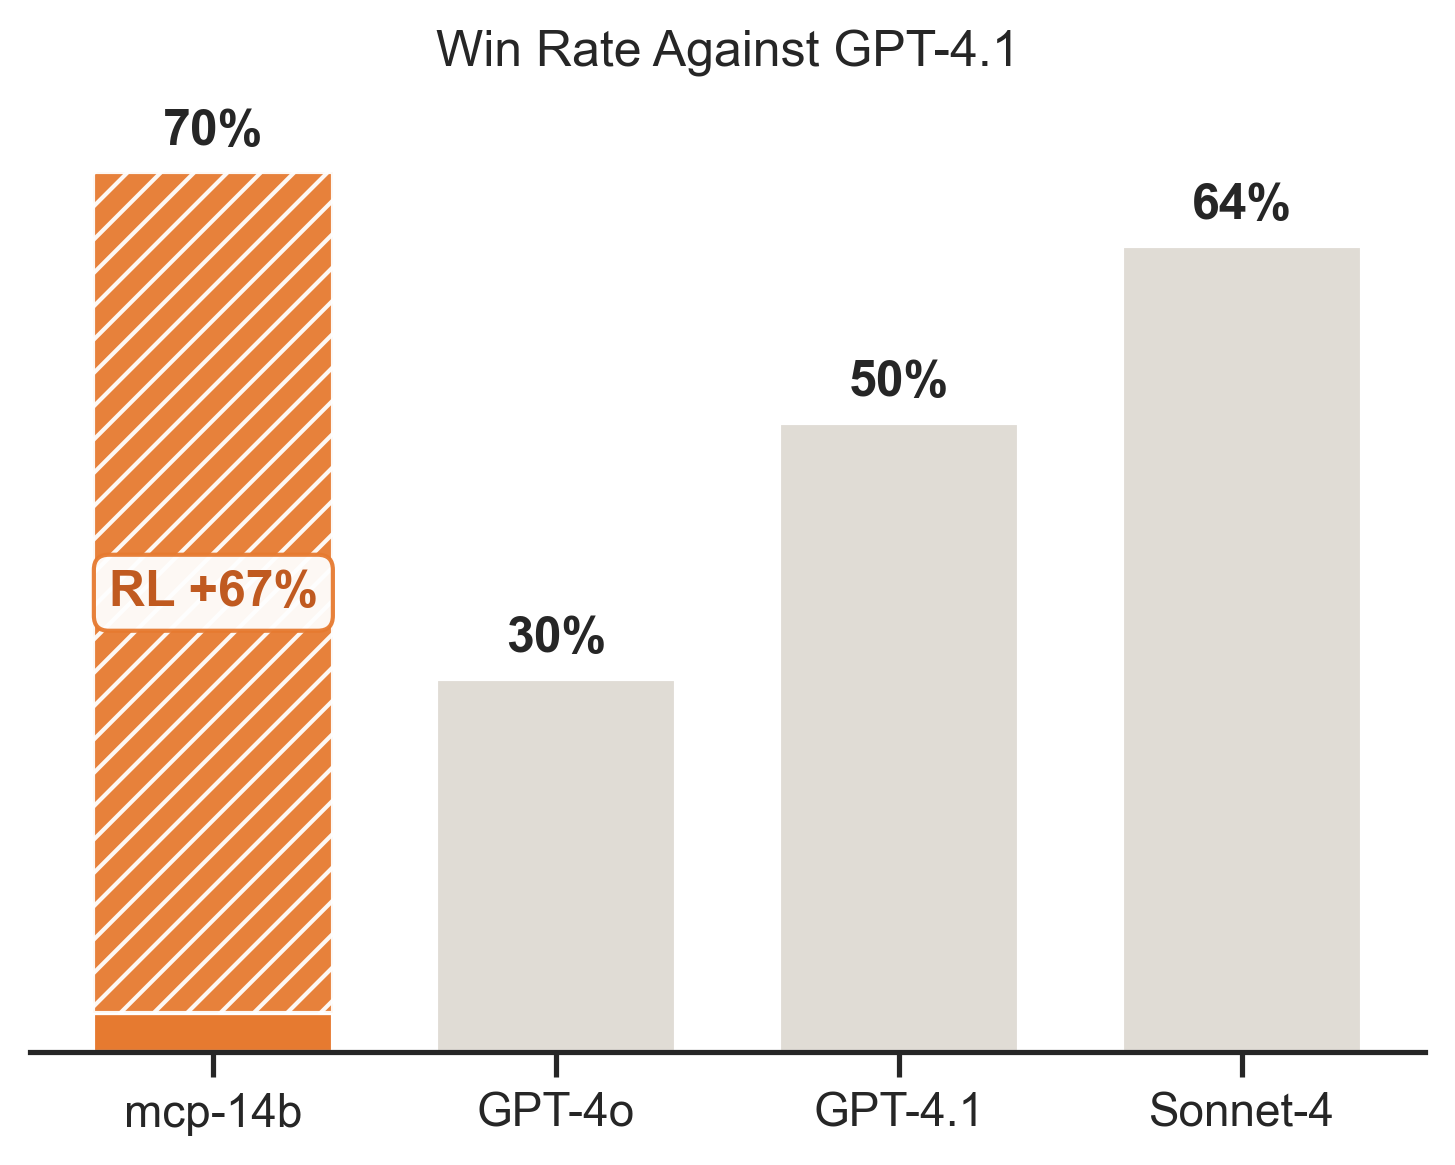

In [95]:
bar_chart = percentage_comparison_bar_chart(
    df,
    metric_name="beat_comp_control_last",
    models=[
        BenchmarkModelKey("mcp-14b-alpha-004", "mcp-14b", "val"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("sonnet-4", "Sonnet-4"),
    ],
    title="Win Rate Against GPT-4.1",
)
bar_chart.savefig(f"{benchmarks_dir}/accuracy-comparison.svg")